## 요약
- RF
- XGB
- NN

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 그래프의 폰트 출력을 선명하게 (svg, retina 등이 있음)
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("default")
# 이미지가 레이아웃 안으로 들어오도록 함
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
mpl.rcParams.update({"figure.constrained_layout.use": True})

#font, line, marker 등의 배율 설정: paper, notebook, talk, poster
sns.set_context("paper") 
#배색 설정: tab10, Set2, Accent, husl
sns.set_palette("Set2") 
#눈금, 배경, 격자 설정: ticks, white, whitegrid, dark, darkgrid
# withegrid: 눈금을 그리고, 각 축의 눈금을 제거
sns.set_style("whitegrid") 

In [3]:
# 로컬에서 

plt.rc("font", family = "D2Coding")
plt.rcParams["axes.unicode_minus"] = False

In [4]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [5]:
PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/'
save_dir = 'processed/model_input'
dir_path = os.path.join(PRJCT_PATH,save_dir)

In [6]:
import pickle

def load_pkl(file_path):
    with open(file_path,'rb') as f:
        data = pickle.load(f)

    return data

In [251]:
data_type = 'sample'
ver=0.8
strat= False
X_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_train.pkl'.format(data_type,ver,strat)))
X_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_val.pkl'.format(data_type,ver,strat)))
X_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_test.pkl'.format(data_type,ver,strat)))
y_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_train.pkl'.format(data_type,ver,strat)))
y_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_val.pkl'.format(data_type,ver,strat)))
y_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_test.pkl'.format(data_type,ver,strat)))

In [252]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(44952, 68)

(11239, 68)

(14048, 68)

(44952,)

(11239,)

(14048,)

**remove some col**
- -1 : SalesPoint
- -2 : RglrPrice

In [253]:
#crop,crop_idx = False,[-1,-2]
#crop,crop_idx = True,[-2]
crop,crop_idx = True,[-1]
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : X_train.shape[1]+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2: 
        X_train = np.hstack([X_train[:,:i],X_train[:,i+1:]])
        X_val = np.hstack([X_val[:,:i],X_val[:,i+1:]])
        X_test = np.hstack([X_test[:,:i],X_test[:,i+1:]])

[67]


In [254]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(44952, 67)

(11239, 67)

(14048, 67)

(44952,)

(11239,)

(14048,)

In [255]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [256]:
import sys
sys.path.append(PRJCT_PATH)

from module_aladin.reg_tool import *

In [257]:
make_reg_score_entire

<function module_aladin.reg_tool.make_reg_score_entire(dict_data, dict_rslt, print_rslt=False)>

## RF

In [258]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train,y_train)

RandomForestRegressor()

In [259]:
y_pred1 = model_rf.predict(X_train)
y_pred2 = model_rf.predict(X_val)
y_pred3 = model_rf.predict(X_test)

In [260]:
display(y_pred1.shape)
display(y_train.shape)

(44952,)

(44952,)

In [261]:
dict_data = {
    'train':{'X':X_train,'y':y_train},
    'val':{'X':X_val,'y':y_val},
    'test':{'X':X_test,'y':y_test},
}
dict_rslt = {
    'train':y_pred1,
    'val':y_pred2,
    'test':y_pred3,
}


In [262]:
reg_score_dict = make_reg_score_entire(dict_data,dict_rslt,print_rslt=True)

train
r2 score : 0.99634
rmse_model : 238.77731 / rmse_base : 3944.70327	 mape_model : 0.01980 / mape_base : 0.33749	
------------------------------------------------------------------------------------------------------------------------------------------------------
val
r2 score : 0.97725
rmse_model : 587.51639 / rmse_base : 3894.79405	 mape_model : 0.04771 / mape_base : 0.33670	
------------------------------------------------------------------------------------------------------------------------------------------------------
test
r2 score : 0.97685
rmse_model : 596.49463 / rmse_base : 3920.41533	 mape_model : 0.04985 / mape_base : 0.33554	
------------------------------------------------------------------------------------------------------------------------------------------------------


In [263]:
def plot_reg_score(dict_data,dict_rslt,dict_score):
    fig,axes = plt.subplots(len(dict_data),3,figsize=(15,4*len(dict_data)))
    for n, (col,data) in enumerate(dict_data.items()):
        ax_row = axes[n] if len(dict_data) > 1 else axes
        ax1, ax2, ax3 = ax_row[0], ax_row[1], ax_row[2]
        y_actual, y_pred = (data['y'], dict_rslt[col])
        train_y = dict_data['train']['y']
        base_pred = np.mean(train_y)

        sns.histplot(y_actual,label='actual',ax=ax1,alpha=0.5)
        sns.histplot(y_pred,label='pred',ax=ax1,alpha=0.5)
        ax1.legend(fontsize=9)

        sns.histplot(y_actual-base_pred,ax=ax2, label = 'baseline',alpha=0.5)
        sns.histplot(y_actual-y_pred,ax=ax2, label = 'pred',alpha=0.5)
        ax2.legend(fontsize=9)
        ax2.set_title('distribution of errors',fontsize=10)

        df_score = pd.DataFrame(dict_score[col]).T[[1,0]]
        xs = list(chain.from_iterable(repeat(val,2) for val in df_score.index))
        ax3r = ax3.twinx()
        sns.barplot(x=xs[:2],y=list(df_score.values.reshape(-1))[:2],
                    hue = ['pred','base']*1,ax=ax3,alpha=0.65,legend=False)
        sns.barplot(x=xs[2:],y=list(df_score.values.reshape(-1))[2:],
                    hue = ['pred','base']*3,ax=ax3r,alpha=0.8,legend=False)
        ax3r.set_ylim([0.0,1.15])
        ax3r.bar_label(ax3r.containers[0], fontsize=8, fmt='%.4f')
        ax3r.bar_label(ax3r.containers[1], fontsize=8, fmt='%.4f')
        ax3.grid(False)
        ax3r.grid(False)
        ax3r.set_yscale('linear')    
        ax3.bar_label(ax3.containers[0], fontsize=8, fmt='%.4f')
        ax3.bar_label(ax3.containers[1], fontsize=8, fmt='%.4f')
        ax3.set_title('model score',fontsize=10)

        ax1.set_title(str_cutter(col+':distribution of data',50),fontsize=15,loc='left',ha='left')
        ax2.xaxis.set_label_coords(-0.02, -0.15)
        ax2.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>48}\n'.format(*dict_score[col]['rmse'],dict_score[col]['r2_score'][0],
            f'n = {len(y_actual)}'), fontsize=10,ha ='left')
        ax1.set_xlabel('')
        ax3.set_xlabel('')
        ax1.set_ylabel('count',fontsize =10) 
        ax2.set_ylabel('count',fontsize =10) 
        plt.setp(ax3.get_yticklabels(),rotation = 0, fontsize = 9, color='#333333')
        plt.setp(ax3r.get_yticklabels(),rotation = 0, fontsize = 9)

    for ax in axes.flatten():
        plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
        plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)

    return fig, axes

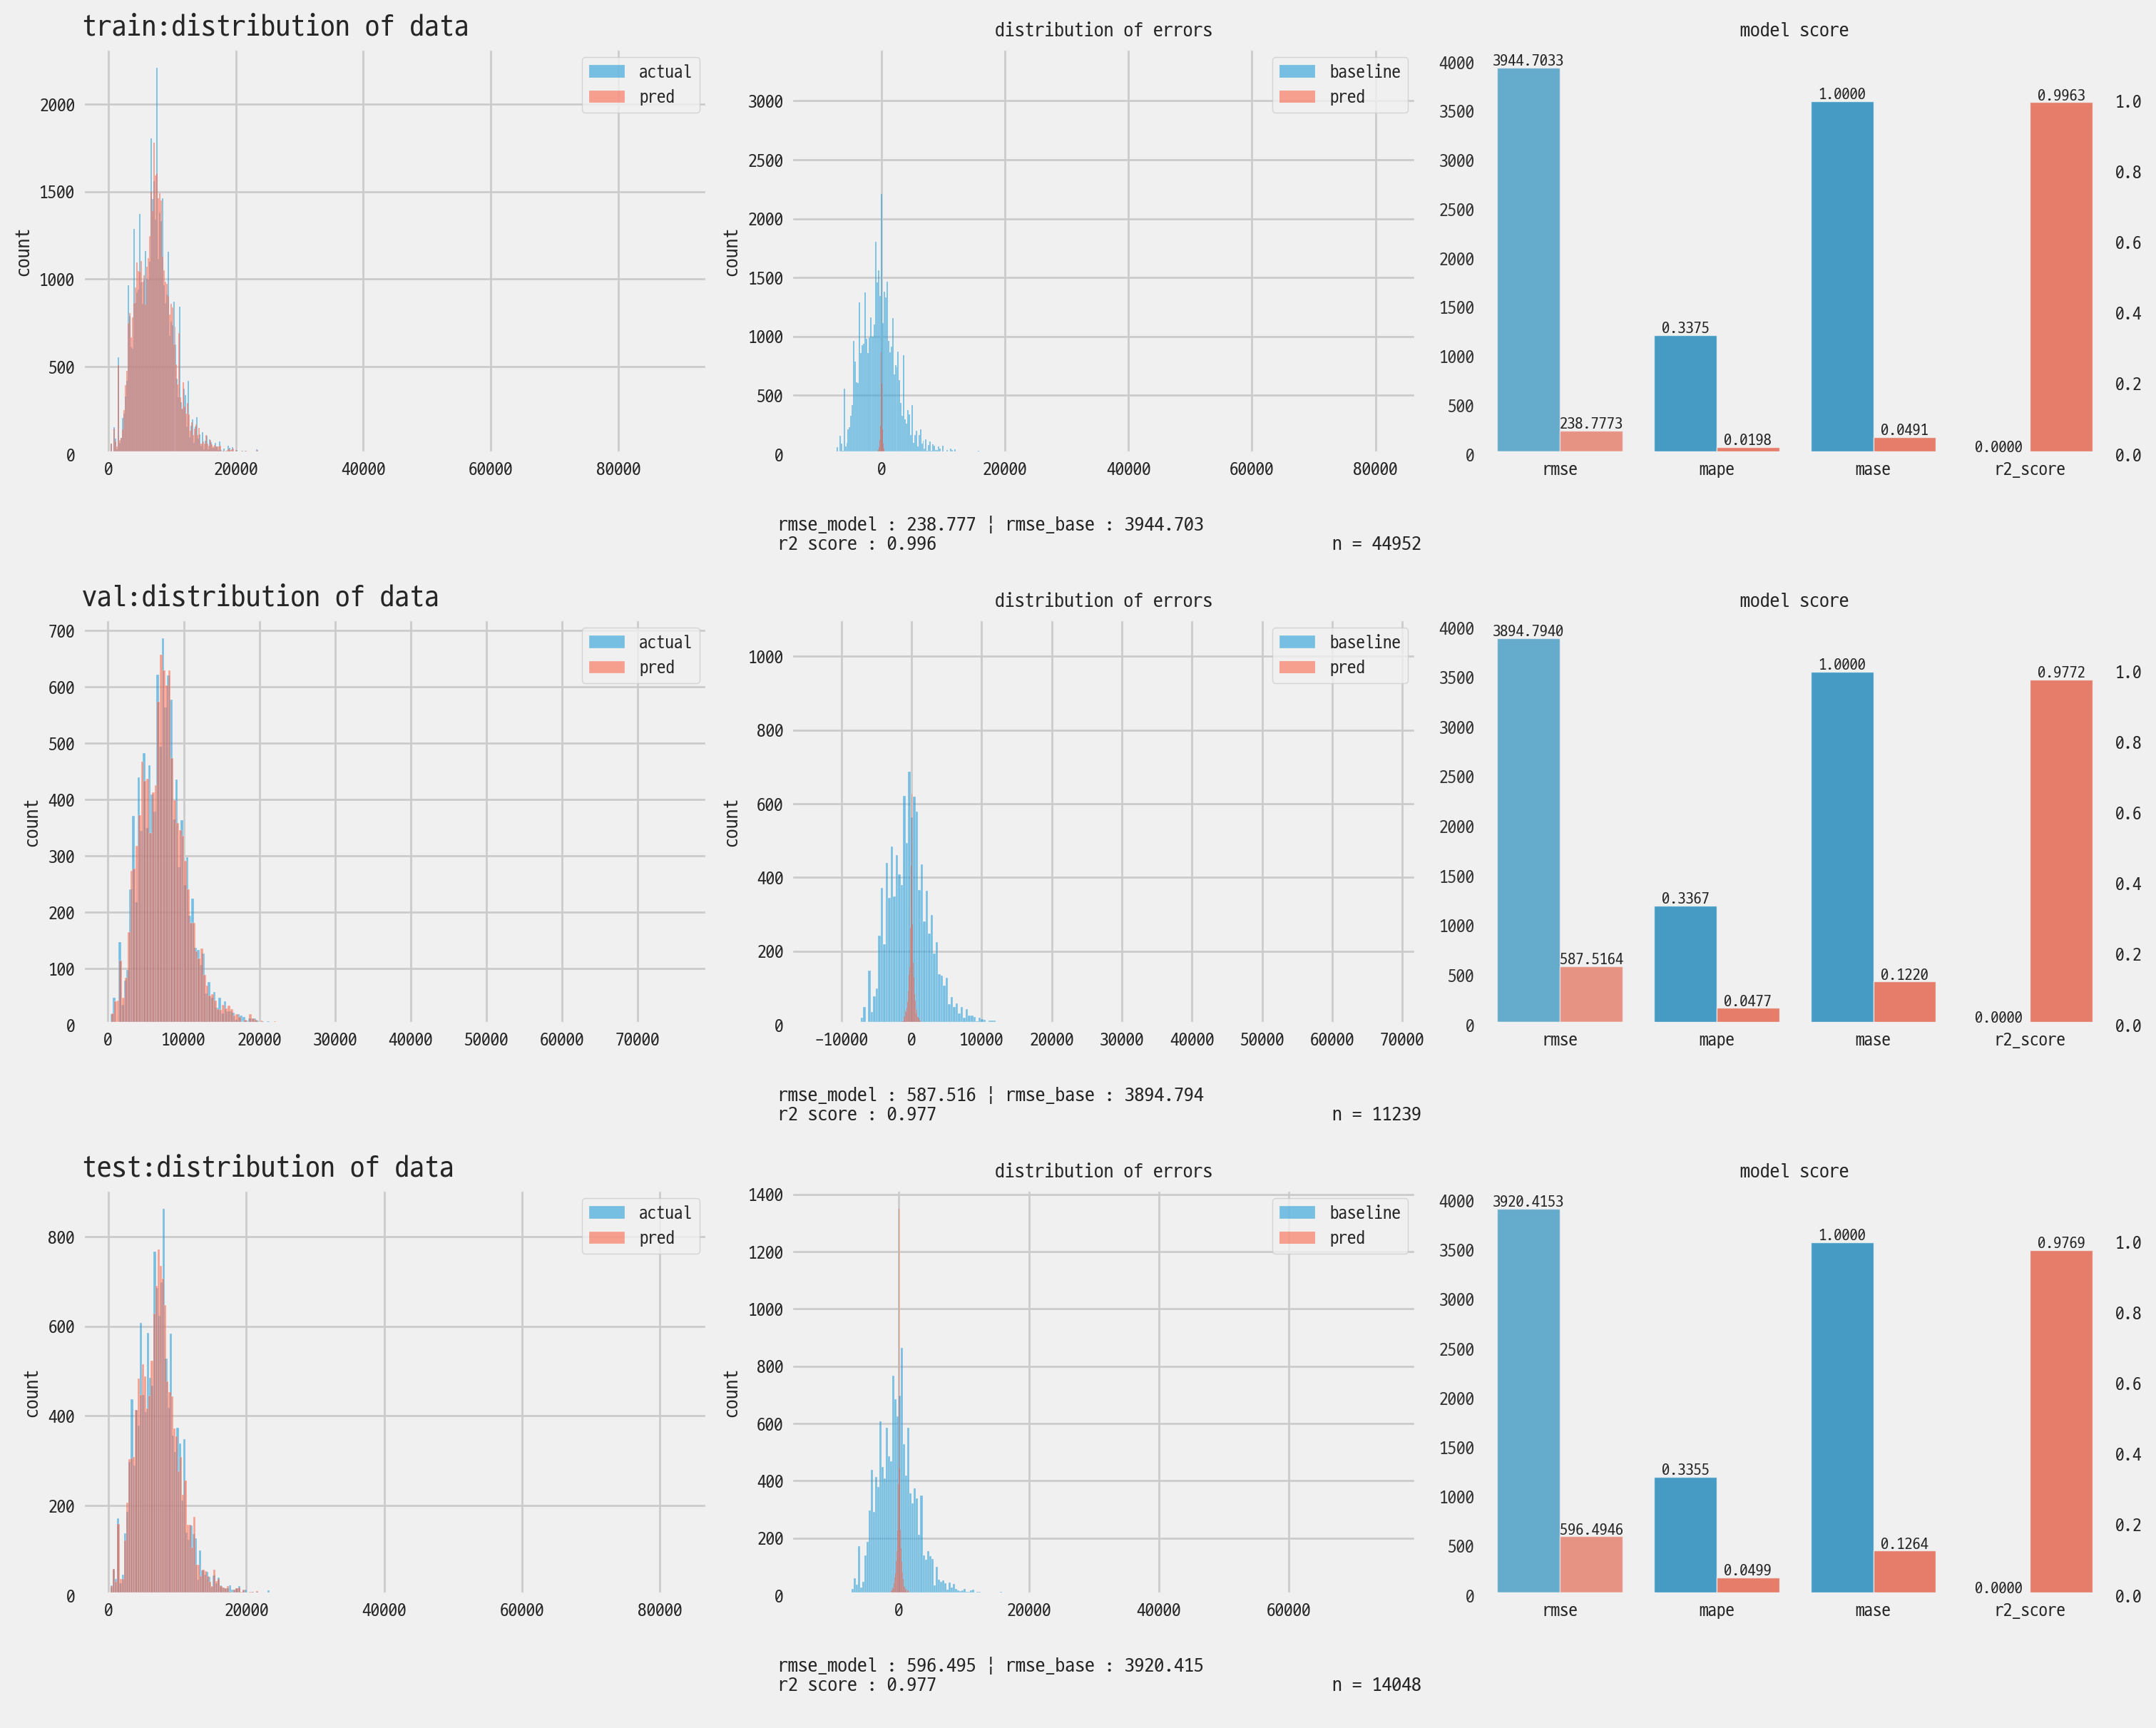

In [264]:
plot_reg_score(dict_data,dict_rslt,reg_score_dict);

In [265]:
rf_FI = model_rf.feature_importances_

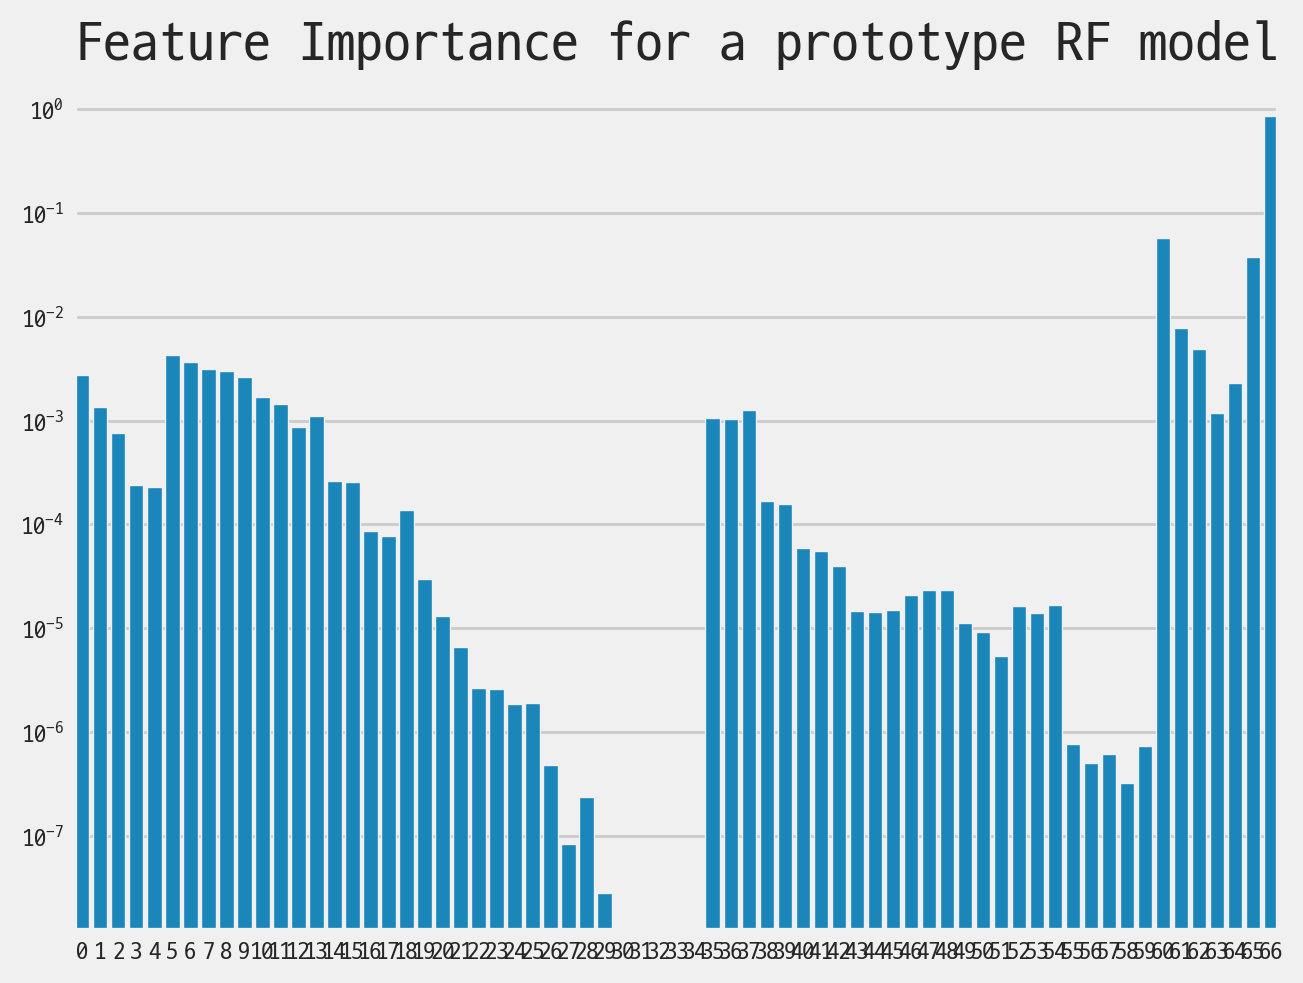

In [266]:
fig,ax = plt.subplots()
sns.barplot(rf_FI,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for a prototype RF model')
#ax.set_xticklabels([])
pass

- (0,5) : category
- (5,35) : BName
- (35,60) : BName_sub

In [284]:
col_vector = ['Category','BName','BName_sub']

In [285]:
crop, crop_idx

(True, [-1])

In [288]:
col_scalar=['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
# 'SlsPrice',
 'SalesPoint']
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : len(col_scalar)+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2: 
        col_scalar =col_scalar[:i]+col_scalar[i+1:]
col_scalar

[7]


['quality', 'store', 'Author', 'Author_mul', 'Publshr', 'Pdate', 'RglPrice']

In [289]:
col_partition = [(0,5),(5,35),(35,60)]+[(60+i,61+i) for i in range(len(col_scalar))]
col_partition

[(0, 5),
 (5, 35),
 (35, 60),
 (60, 61),
 (61, 62),
 (62, 63),
 (63, 64),
 (64, 65),
 (65, 66),
 (66, 67)]

In [290]:
cols_setting = list(zip(col_vector+col_scalar,col_partition))
concatted_FI = dict()
for (col,partition) in cols_setting:
    concatted_FI[col] = np.sum(rf_FI[partition[0]:partition[1]])
concatted_FI, sum(list(concatted_FI.values()))

({'Category': 0.005359101205953698,
  'BName': 0.02278969212833364,
  'BName_sub': 0.004033961583060827,
  'quality': 0.057673938226199394,
  'store': 0.0077812988584905615,
  'Author': 0.004937264110228691,
  'Author_mul': 0.001173989103163102,
  'Publshr': 0.0022927305525960295,
  'Pdate': 0.037508944044481275,
  'RglPrice': 0.8564490801874928},
 1.0)

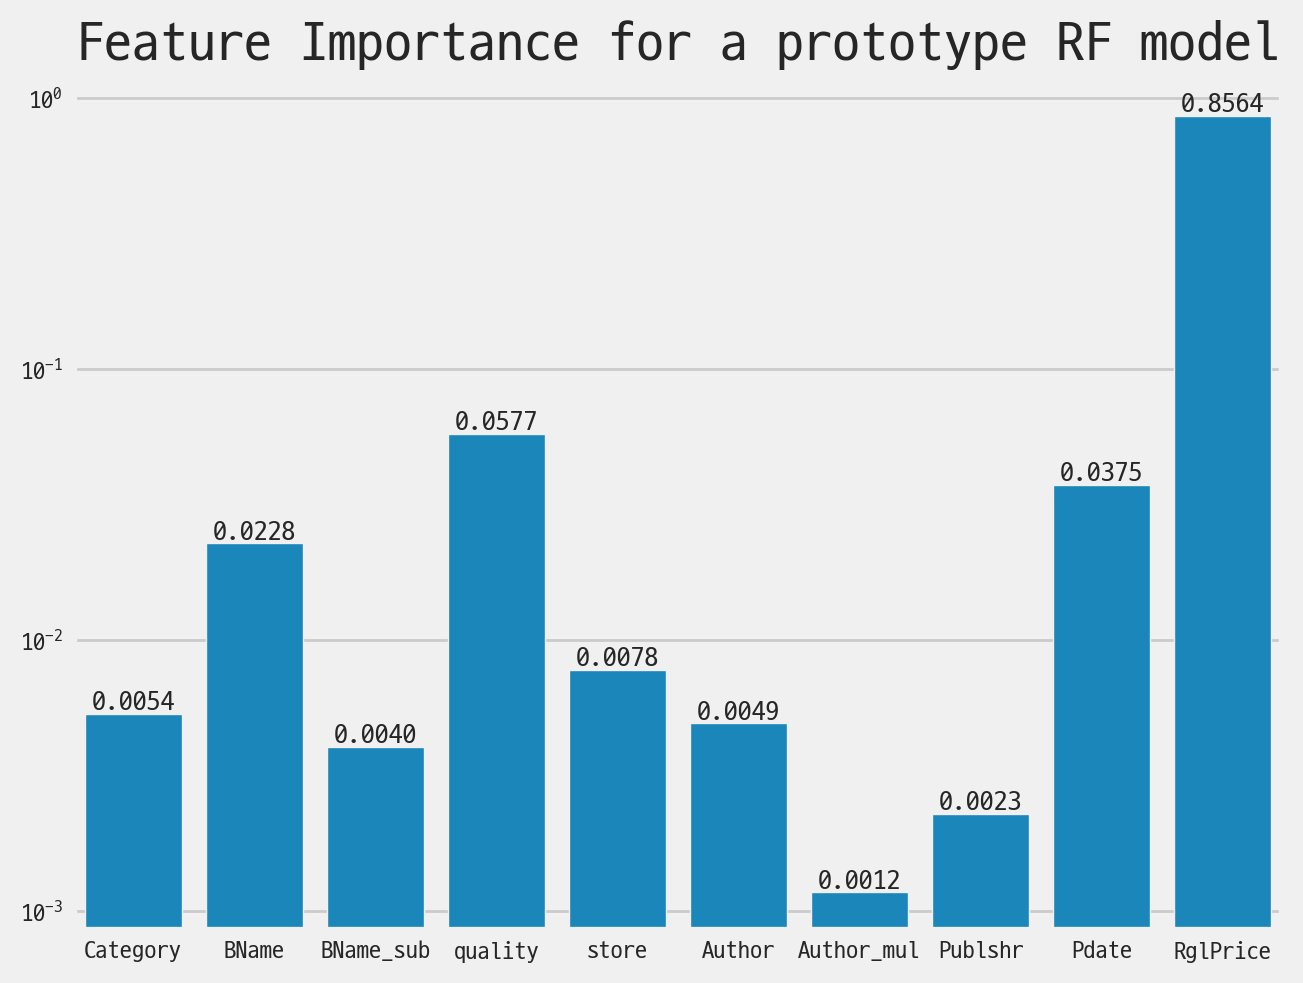

In [291]:
fig,ax = plt.subplots()
sns.barplot(concatted_FI,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for a prototype RF model')
ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
#ax.set_xticklabels([])
pass

Text(0.5, 1.0, 'distribution of absolute errors')

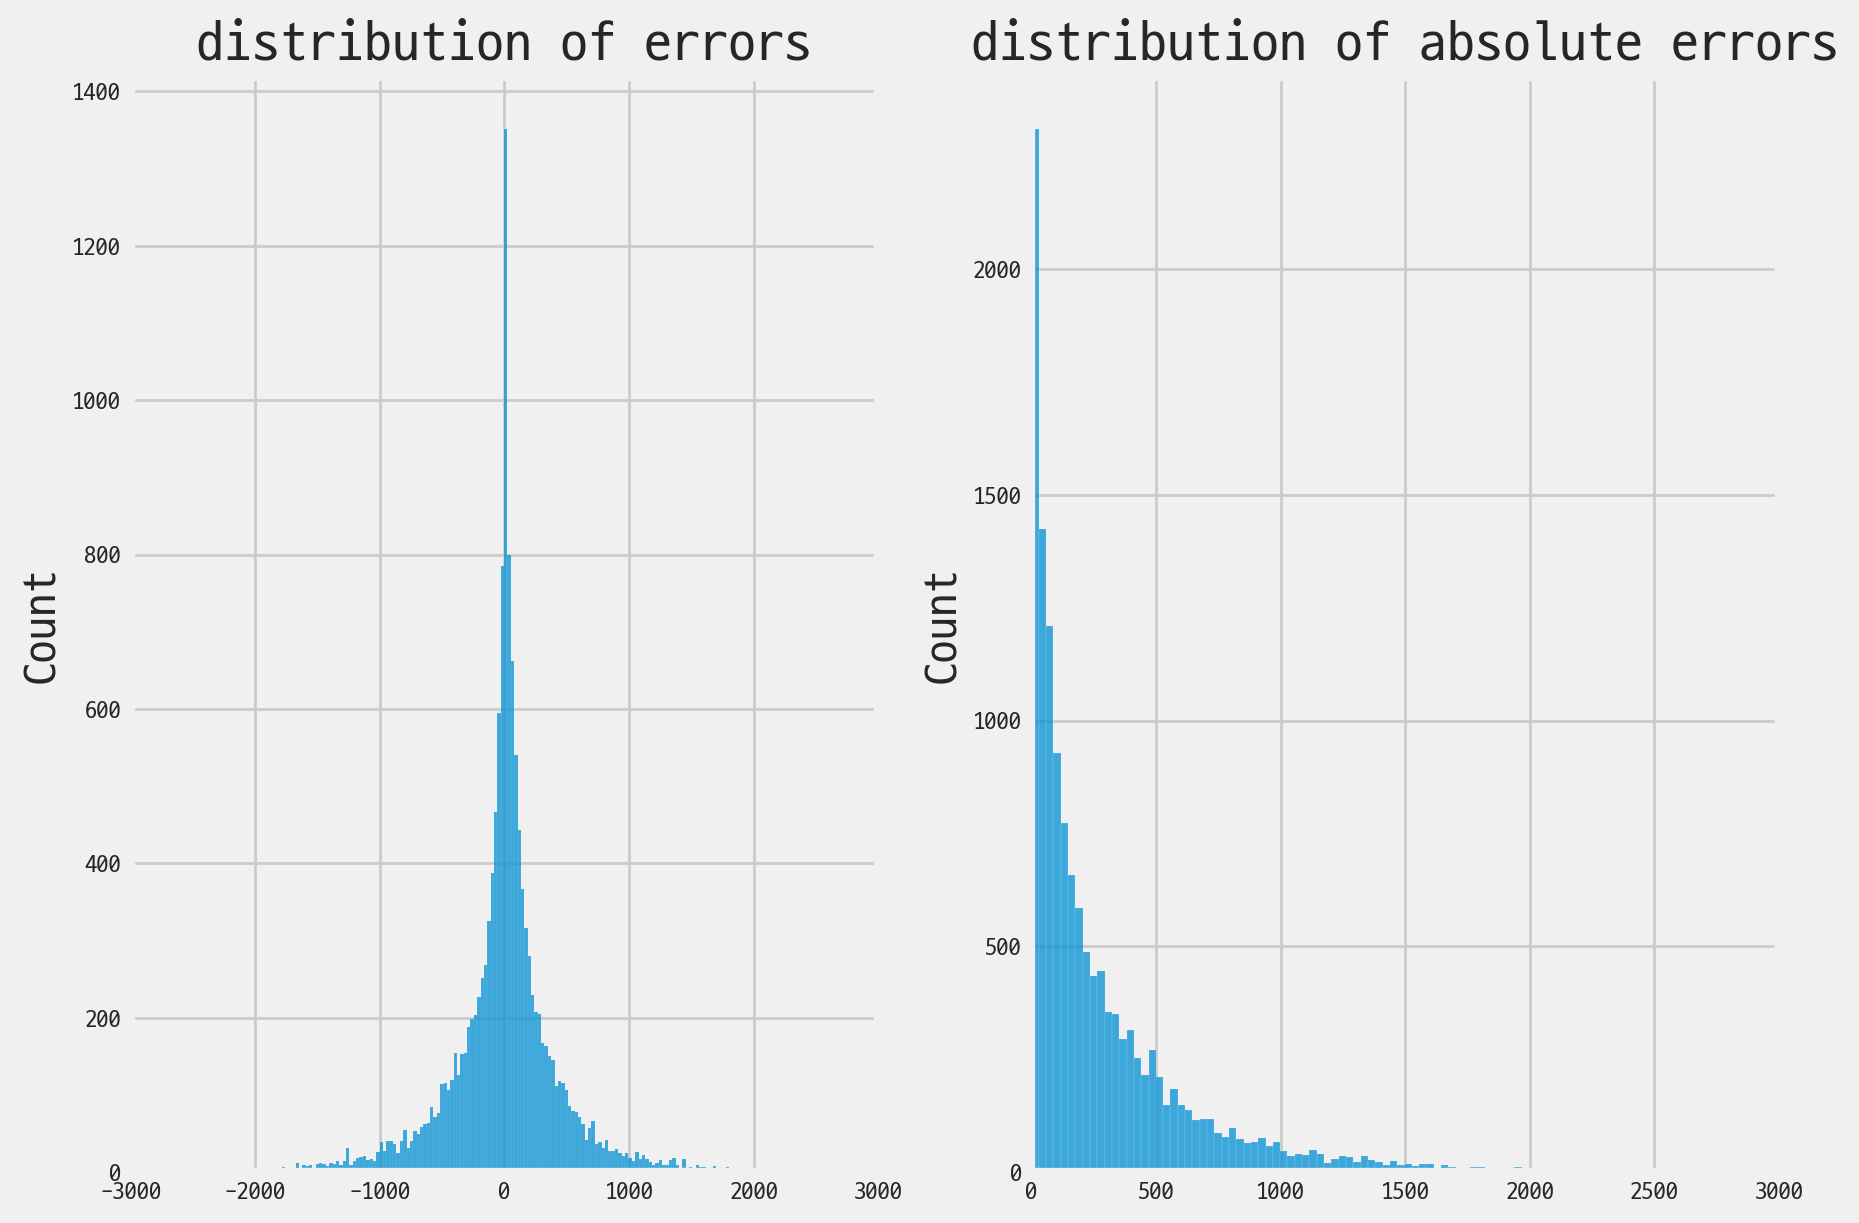

In [273]:
fig,axes = plt.subplots(1,2,figsize = (9,6))
sns.histplot((dict_data['test']['y']-dict_rslt['test']),ax=axes[0])
axes[0].set_xlim([-3000,3000])
axes[0].set_title('distribution of errors')
sns.histplot(np.abs(dict_data['test']['y']-dict_rslt['test']),ax=axes[1])
axes[1].set_xlim([0,3000])
axes[1].set_title('distribution of absolute errors')
#ax.set_yscale('log');

- 만약 ItemId가 포함되지 않은 것들로 test set을 추리면 어떻게 될까

In [274]:
RSLT_DIR = PRJCT_PATH + 'processed/' 
ver, strat = 0.8, False
file_name = 'data_splitted_ver{}_strat-{}.pkl'.format(ver,strat)
file_path = os.path.join(RSLT_DIR,file_name)
data = load_pkl(file_path)

file_name = 'bookinfo_ver{}.csv'.format(0.8)
file_path = os.path.join(RSLT_DIR,file_name)
bookinfo = pd.read_csv(file_path)

items=dict()
for mode,sample in data.items():
    items[mode]= set(sample['X']['ItemId'].values)

In [275]:
display(len(items['val'].difference(items['train'])))
display(len(items['test'].difference(items['train'])))


152

204

In [276]:
res_val = list(items['val'].difference(items['train']))
res_test = list(items['test'].difference(items['train']))
res_items = res_val+res_test
len(res_items)

356

In [277]:
cond_val_res = data['val']['X']['ItemId'].isin(res_val).to_numpy()
cond_test_res = data['test']['X']['ItemId'].isin(res_val).to_numpy()
display(np.sum(cond_val_res))
display(np.sum(cond_test_res))

174

38

In [278]:
len(cond_val_res)

11239

In [279]:
len(y_val[cond_val_res]),len(y_test[cond_test_res])

(174, 38)

In [280]:
X_res = np.vstack((X_val[cond_val_res],X_test[cond_test_res]))
y_res = np.hstack((y_val[cond_val_res],y_test[cond_test_res]))
X_res.shape, y_res.shape

((212, 67), (212,))

In [281]:
pred4 = model_rf.predict(X_res)

In [282]:
make_reg_score_dict(y_res,pred4,np.mean(y_train))

{'rmse': [1372.7519183087431, 7389.843770755887],
 'mape': [0.09096824073482723, 0.6303601181106109],
 'mase': [0.13989679063367697, 1],
 'r2_score': [0.9654817126229491, 0]}

Text(0.5, 1.0, 'distribution of absolute errors')

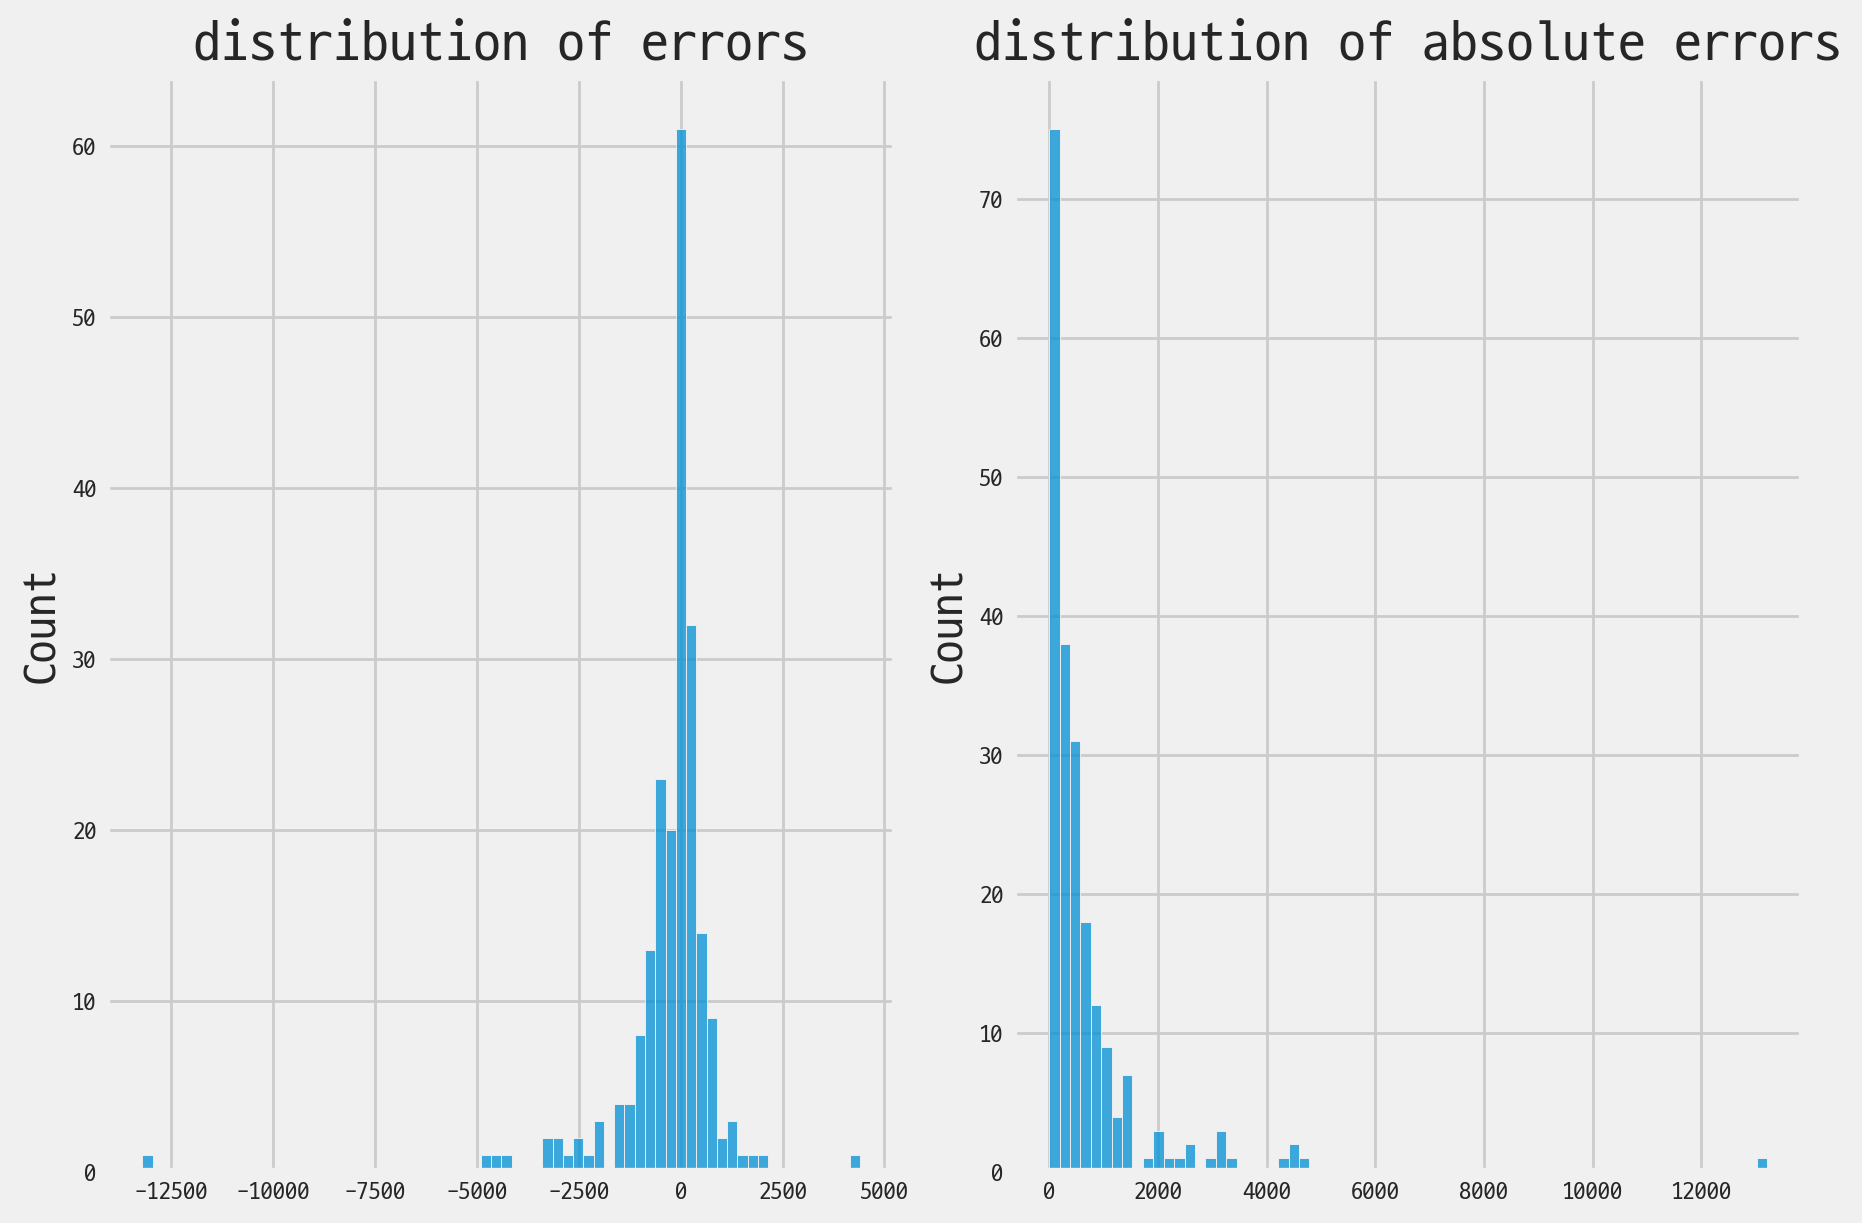

In [283]:
fig,axes = plt.subplots(1,2,figsize = (9,6))
sns.histplot((y_res-pred4),ax=axes[0])
#axes[0].set_xlim([-3000,3000])
axes[0].set_title('distribution of errors')
sns.histplot(np.abs(y_res-pred4),ax=axes[1])
#axes[1].set_xlim([0,3000])
axes[1].set_title('distribution of absolute errors')
#ax.set_yscale('log');

## XGB